# Description

Алгоритмы кредитного скоринга, которые предполагают вероятность дефолта, — это метод, который банки используют для определения того, следует ли предоставлять кредит. Этот конкурс требует, чтобы участники улучшили состояние дел в кредитном скоринге, предсказывая вероятность того, что кто-то испытает финансовые затруднения в следующие два года.

Целью  $\href{https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption}{этого}$ конкурса является создание модели, которую заемщики смогут использовать для принятия наилучших финансовых решений.
- `SeriousDlqin2yrs` - просрочка платежа на 90 и больше дней. Целевой признак.
- `RevolvingUtilizationOfUnsecuredLines` — общий баланс по кредитным картам и личным кредитным линиям, за исключением недвижимости и долга без рассрочки, такого как автокредиты, разделенный на сумму кредитных лимитов.
- `age` - возраст заемщика в годах
- `NumberOfTime30-59DaysPastDueNotWorse` — количество раз, когда заемщик просрочил платеж на 30–59 дней, но не более того, за последние 2 года.
- `DebtRatio` - ежемесячные платежи по долгам, алименты, расходы на проживание, деленные на месячный валовой доход
- `MonthlyIncome` - ежемесячный доход
- `NumberOfOpenCreditLinesAndLoans` — количество открытых кредитов (в рассрочку, таких как автокредит или ипотека) и кредитных линий (например, кредитных карт)
- `NumberOfTimes90DaysLate` — количество раз, когда заемщик просрочил платеж на 90 дней или более.
- `NumberRealEstateLoansOrLines` — количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии под залог жилья.
- `NumberOfTime60-89DaysPastDueNotWorse` — количество раз, когда заемщик просрочил платеж на 60–89 дней, но не более того, за последние 2 года.
- `NumberOfDependents` — количество иждивенцев в семье, исключая их самих (супруг, дети и т. д.)


# Import libraries

In [373]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve, roc_curve

from scipy.stats import shapiro
from collections import Counter

# Models
from sklearn.linear_model import  LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# EDA

In [374]:
df = pd.read_csv("data/cs-training.csv", index_col = 0)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [306]:
test = pd.read_csv("data/cs-test.csv", index_col= 0)
test.shape

(101503, 11)

In [307]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

<AxesSubplot: >

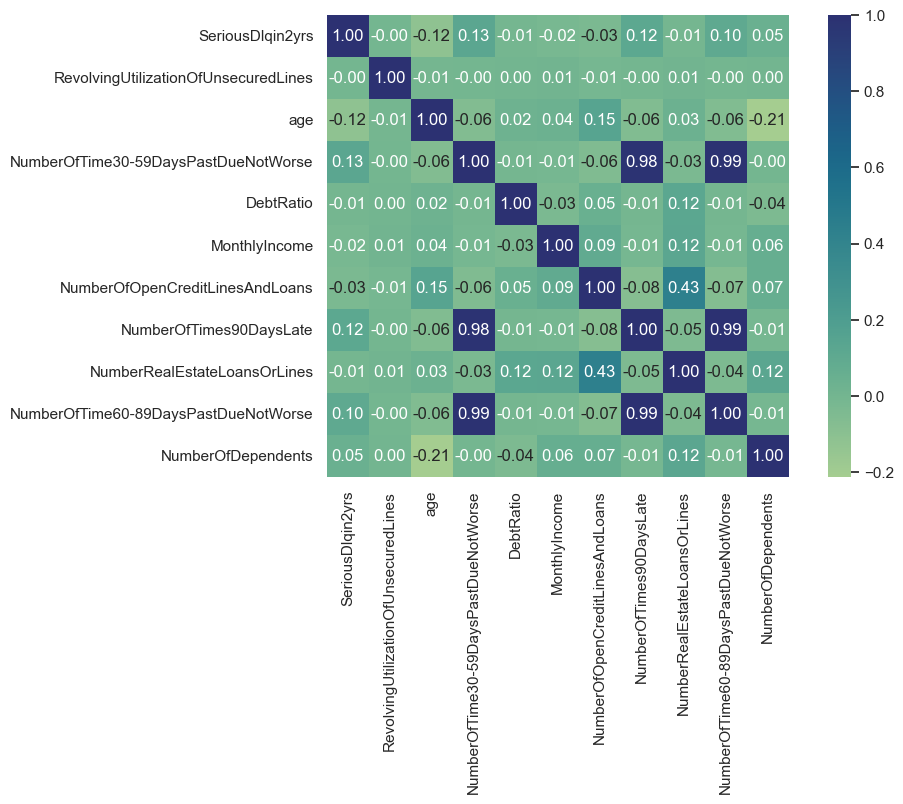

In [308]:
sns.set()
plt.subplots(figsize=(10,6))
sns.heatmap(
df.corr(method='pearson'),
    cmap="crest",
    annot = True,
    square=True,
    fmt ='.2f',
)

In [309]:
def percent_missing(df):
    missing_num = df[df.columns].isna().sum().sort_values(ascending=False)
    missing_perc = (df[df.columns].isna().sum()/len(df)*100).sort_values(ascending=False)
    missing_data = pd.concat([missing_num,missing_perc],keys=['Total','Percentage'],axis=1)
    missing_data = missing_data[missing_data['Percentage']>0]
       
    return missing_data

In [310]:
percent_missing(df)

,Total,Percentage
MonthlyIncome,29731,19.820667
NumberOfDependents,3924,2.616000


<AxesSubplot: xlabel='SeriousDlqin2yrs', ylabel='count'>

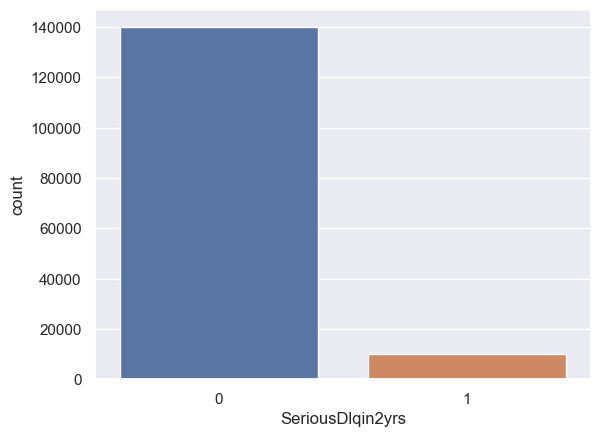

In [311]:
sns.countplot(df, x = 'SeriousDlqin2yrs')

In [312]:
print("Процент людей, просрочивших кредит: {} %".format(round(df["SeriousDlqin2yrs"].sum() / len(df) * 100, 2)))

Процент людей, просрочивших кредит: 6.68 %


In [313]:
df["RevolvingUtilizationOfUnsecuredLines"].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

(-2611.3994630522943, 53319.399463052294, 0.0, 1e-06)

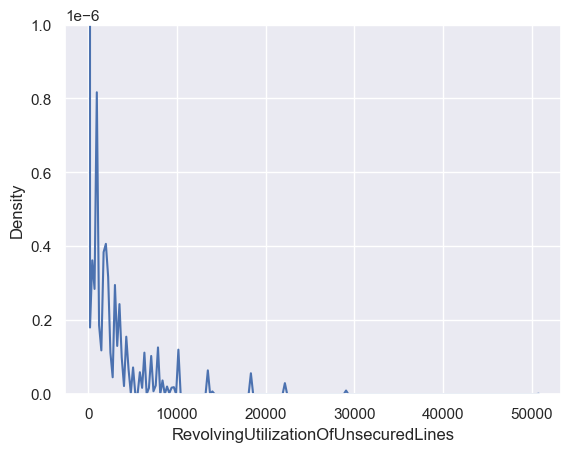

In [314]:
ax = sns.kdeplot(df["RevolvingUtilizationOfUnsecuredLines"])
ax.axis(ymin=0.0,ymax=0.000001)

In [315]:
print("Процент должников с задолжностью не превышающий лимит по кредиту: {} %"\
     .format(round(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] <= 1)]["SeriousDlqin2yrs"].mean() * 100, 2)))

Процент должников с задолжностью не превышающий лимит по кредиту: 5.99 %


<AxesSubplot: xlabel='RevolvingUtilizationOfUnsecuredLines'>

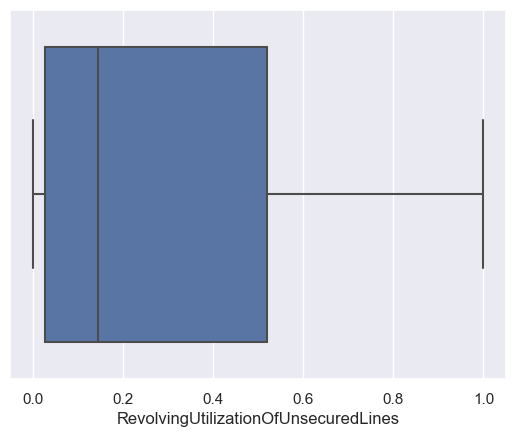

In [316]:
sns.boxplot(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] <= 1)], x = "RevolvingUtilizationOfUnsecuredLines")

<AxesSubplot: xlabel='RevolvingUtilizationOfUnsecuredLines'>

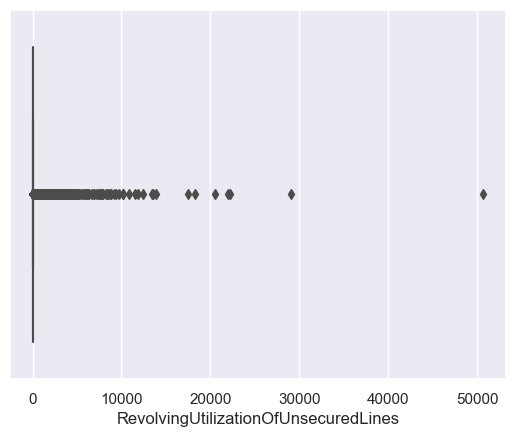

In [317]:
sns.boxplot(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] > 1)], x = "RevolvingUtilizationOfUnsecuredLines")

In [318]:
df[df["RevolvingUtilizationOfUnsecuredLines"] > 2]['RevolvingUtilizationOfUnsecuredLines'].describe()

count      371.000000
mean      2316.264874
std       4463.548126
min          2.003992
25%          3.401210
50%        815.000000
75%       2835.500000
max      50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [319]:
print("Процент должников с задолжностью не превышающий  2-х кратный лимит по кредиту: {} %"\
     .format(round(df.loc[(df["RevolvingUtilizationOfUnsecuredLines"] <= 2)]["SeriousDlqin2yrs"].mean() * 100, 2)))

Процент должников с задолжностью не превышающий  2-х кратный лимит по кредиту: 6.66 %


После 2-х кратного уввеличения задолжности происходит резкий скачок по этому параметру.

In [320]:
df["age"].describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [321]:
df[df['age'] <= 0]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


<AxesSubplot: title={'center': 'Box Plot of Age'}, xlabel='age'>

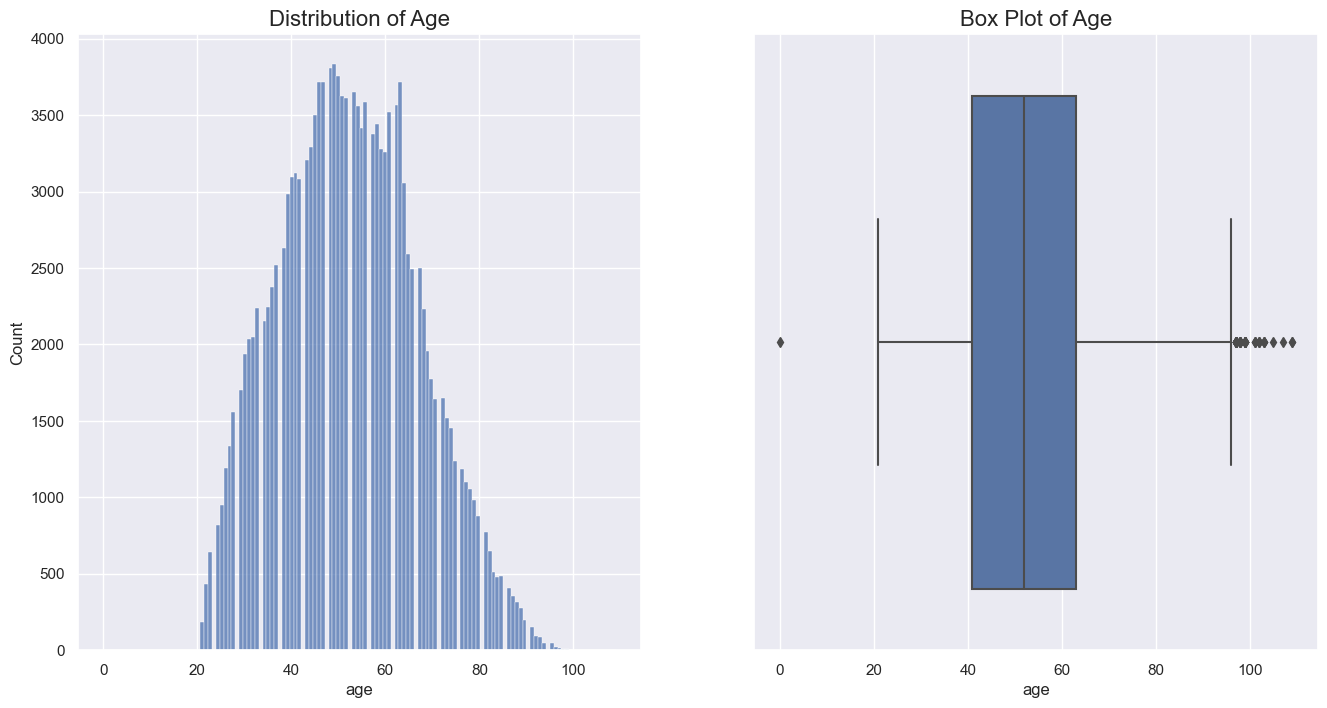

In [381]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

ax[1].set_title('Box Plot of Age', size=16)
sns.histplot(df['age'], ax=ax[0])
ax[0].set_title('Distribution of Age', size=16)
sns.boxplot(x=df["age"], ax=ax[1])
#ax[1].boxplot(df['age'])

<AxesSubplot: xlabel='age', ylabel='Count'>

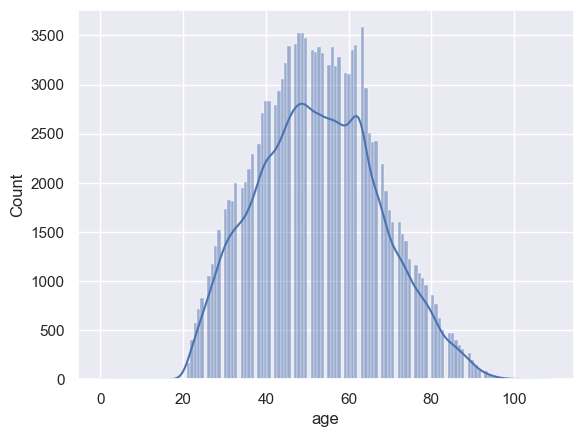

In [335]:
sns.histplot(df.loc[df["SeriousDlqin2yrs"] == 0]["age"], kde= True)

<AxesSubplot: xlabel='age', ylabel='Count'>

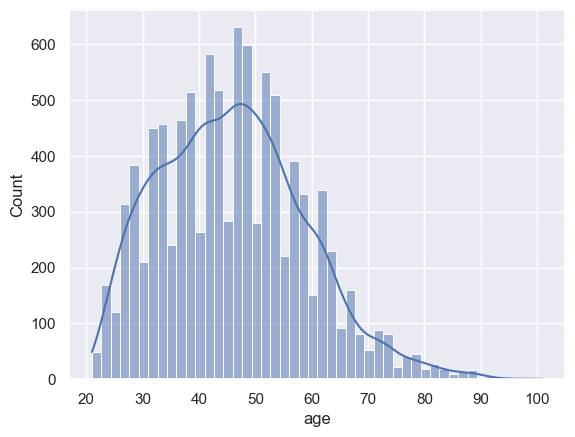

In [336]:
sns.histplot(df.loc[df["SeriousDlqin2yrs"] == 1]["age"], kde= True)

Молодые люди менее склонны к просрочке по кредиту.

In [101]:
number_of_times = ["NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTime30-59DaysPastDueNotWorse"]

In [96]:
for time in number_of_times:
    print(df[time].value_counts().sort_index())

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64
0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64


В выборке нет людей, которые просрочили кредит от 18 до 95 раз.

In [115]:
df.loc[df["NumberOfTimes90DaysLate"] > 17]['SeriousDlqin2yrs'].describe()

count    269.000000
mean       0.546468
std        0.498764
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [120]:
df["DebtRatio"].mean()

353.00507576386985

In [131]:
print("Число людей у которых ежемесячный доход ниже среднего ежемесячного платежа по кредиту: {}"\
     .format(len(df.loc[(df["DebtRatio"] > df["DebtRatio"].mean()) & (df["MonthlyIncome"] < df["DebtRatio"].mean()) ])))

Число людей которые должны платить 2449 и больше у которых нет: 1414


In [136]:
df.loc[(df["DebtRatio"] > df["DebtRatio"].mean()) & (df["MonthlyIncome"] < df["DebtRatio"].mean()) ]['SeriousDlqin2yrs'].value_counts()

0    1356
1      58
Name: SeriousDlqin2yrs, dtype: int64

Из них всего 58 человек кредит просрочили.

In [137]:
df["NumberOfOpenCreditLinesAndLoans"].describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [29]:
df[df['SeriousDlqin2yrs'] == 1]["NumberOfOpenCreditLinesAndLoans"]

1         13
14         9
22         7
26        14
52        10
          ..
149955     3
149956    12
149962     4
149969     2
149980     7
Name: NumberOfOpenCreditLinesAndLoans, Length: 10026, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


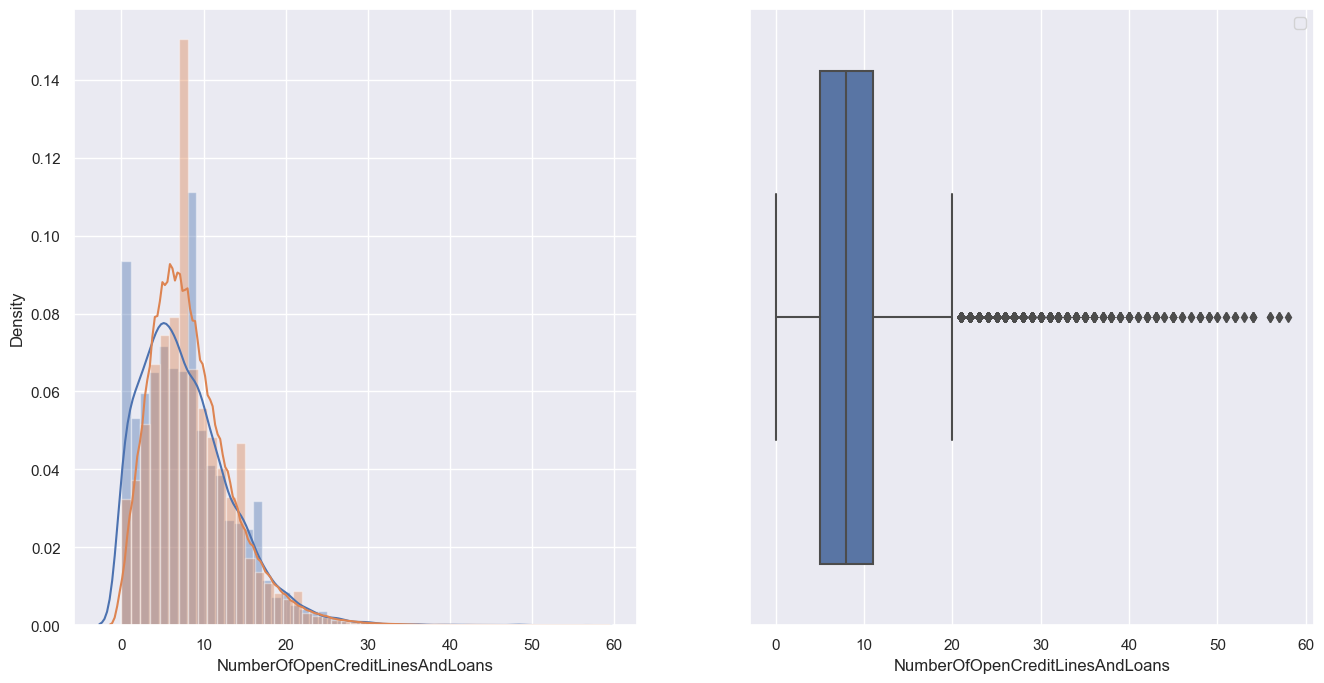

In [382]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
#ax[1].boxplot(df['NumberOfOpenCreditLinesAndLoans'])
sns.boxplot(x=df["NumberOfOpenCreditLinesAndLoans"], ax=ax[1])
data_list = [df[df['SeriousDlqin2yrs'] == 1]["NumberOfOpenCreditLinesAndLoans"],
             df[df['SeriousDlqin2yrs'] == 0]["NumberOfOpenCreditLinesAndLoans"]]

labels = ["Просрочили кредит", "Не просрочили кредит"]
for i, data in enumerate(data_list):
    sns.distplot(data, label=labels[i], kde=True,
                 color=sns.color_palette()[i], ax=ax[0])

plt.legend()
plt.show()

Text(0.5, 1.0, 'Scatter Plot over Target Feature')

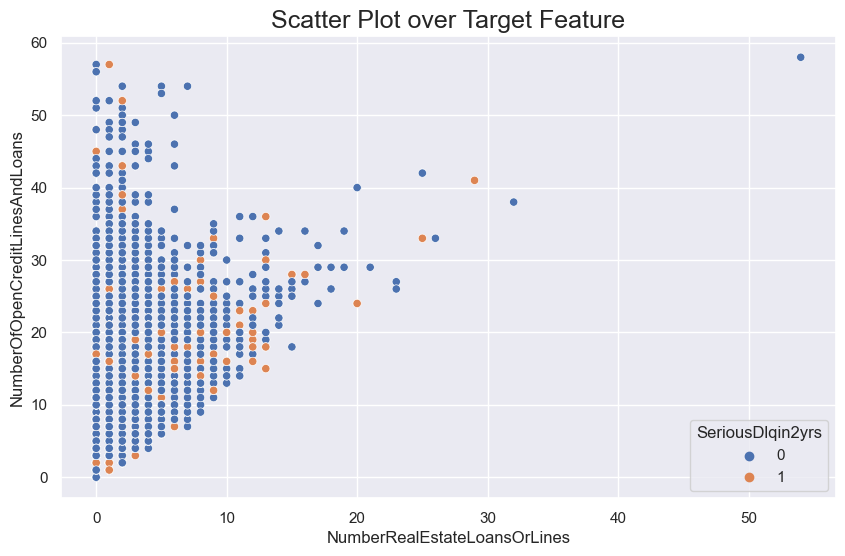

In [324]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='NumberRealEstateLoansOrLines',
                y='NumberOfOpenCreditLinesAndLoans', hue='SeriousDlqin2yrs', data=df)
plt.title('Scatter Plot over Target Feature', size=18)

<AxesSubplot: xlabel='NumberOfOpenCreditLinesAndLoans'>

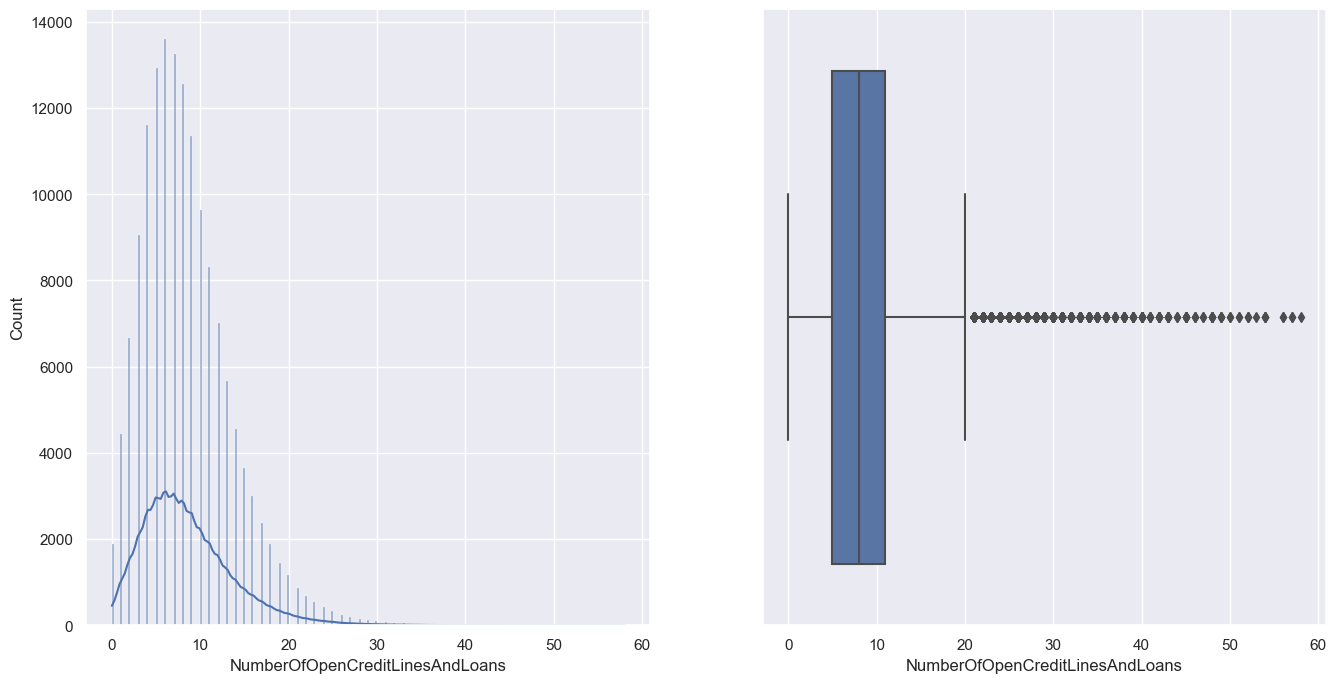

In [383]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

sns.histplot(df['NumberOfOpenCreditLinesAndLoans'], kde=True, ax=ax[0])
sns.boxplot(x = df['NumberOfOpenCreditLinesAndLoans'],ax=ax[1])

<AxesSubplot: xlabel='NumberOfDependents'>

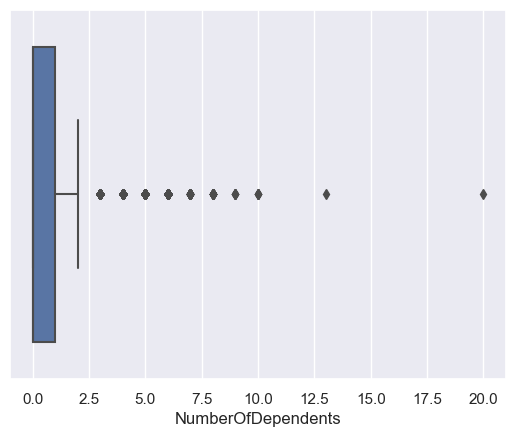

In [384]:
sns.boxplot(x = df['NumberOfDependents'])

# Feature engineering

Удалим полные дубли, так как для модели они не будут нести новой информации.

In [346]:
df[df.duplicated()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1670,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
7824,0,1.0,29,0,0.0,NaN,0,0,0,0,0.0
7921,0,1.0,22,0,0.0,820.0,1,0,0,0,0.0
8841,0,1.0,23,0,0.0,820.0,1,0,0,0,0.0
10870,0,1.0,73,0,0.0,NaN,2,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149140,0,0.0,77,0,0.0,NaN,2,0,0,0,0.0
149432,0,1.0,25,0,0.0,NaN,1,0,0,0,NaN
149473,0,1.0,84,0,0.0,NaN,1,0,0,0,0.0
149770,0,1.0,23,98,0.0,NaN,0,98,0,98,NaN


In [347]:
df.drop_duplicates(inplace= True)

In [348]:
# Удалим всех нольлеток)
df.drop([df[df.age <= 20].reset_index()['index'][0]], axis= 0, inplace= True)

In [349]:
df['istest'] = 0
test['istest'] = 1

raw = pd.concat((df, test)).reset_index(drop=True)

In [32]:
raw

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,istest
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
250888,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0,1
250889,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0,1
250890,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN,1
250891,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0,1


In [55]:
raw['range'] = pd.cut(raw['age'], bins=3,precision=0, labels=['Young','Adult','Elderly'])

In [56]:
raw.groupby(['range']).aggregate({"MonthlyIncome": ['mean', 'median'], "NumberOfDependents": ['mean', 'median']})

MonthlyIncome         NumberOfDependents       
                 mean  median               mean median
range                                                  
Young     6181.514657  5000.0           1.059410    1.0
Adult     7436.043823  5900.0           0.528018    0.0
Elderly   5315.825337  4157.0           0.111665    0.0

In [58]:
raw.loc[(raw.range == "Young") & raw['MonthlyIncome'].isna(),  'MonthlyIncome'] = raw[raw.range == "Young"] \
    .MonthlyIncome.fillna(raw[raw.range == "Young"].MonthlyIncome.median())

raw.loc[(raw.range == "Adult") & raw['MonthlyIncome'].isna(),  'MonthlyIncome'] = raw[raw.range == "Adult"] \
    .MonthlyIncome.fillna(raw[raw.range == "Adult"].MonthlyIncome.median())

raw.loc[(raw.range == "Elderly") & raw['MonthlyIncome'].isna(),  'MonthlyIncome'] = raw[raw.range == "Elderly"] \
    .MonthlyIncome.fillna(raw[raw.range == "Adult"].MonthlyIncome.median())

In [60]:
raw.loc[(raw.range == "Young") & raw['NumberOfDependents'].isna(),  'NumberOfDependents'] = raw[raw.range == "Young"] \
    .MonthlyIncome.fillna(raw[raw.range == "Young"].MonthlyIncome.median())

raw.loc[(raw.range == "Adult") & raw['NumberOfDependents'].isna(),  'NumberOfDependents'] = raw[raw.range == "Adult"] \
    .MonthlyIncome.fillna(raw[raw.range == "Adult"].MonthlyIncome.median())
p
raw.loc[(raw.range == "Elderly") & raw['NumberOfDependents'].isna(),  'NumberOfDependents'] = raw[raw.range == "Elderly"] \
    .MonthlyIncome.fillna(raw[raw.range == "Adult"].MonthlyIncome.median())

In [62]:
percent_missing(raw)

,Total,Percentage
SeriousDlqin2yrs,101503,40.456689


Все пропуски заполнены, осталась только наша целевая переменная.

In [70]:
raw.drop('range', axis= 1, inplace= True)

In [97]:
test = raw[raw.istest == 1]
df = raw[raw.istest == 0]

In [353]:
test.drop('istest', axis=1, inplace=True)
df.drop('istest', axis=1, inplace=True)

In [ ]:
Рассчитаем выбросы по методу Тьюки

In [354]:
def detect_outliers(df,n,features):

    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)

        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [355]:
Outliers_to_drop = detect_outliers(df,3,df.columns.values)
print("Выбросов:",round(len(Outliers_to_drop)/df.shape[0]*100,2),"%")
df.loc[Outliers_to_drop]

Выбросов: 0.01 %


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
2421,1,1.305389,63,1,0.182891,1355.0,3,0,0,1,0.0
8746,1,1.305648,32,1,713.000000,NaN,3,0,0,0,1.0
20411,1,1.323274,41,1,0.329169,1600.0,8,0,0,2,2.0
26277,1,1.311844,40,1,0.625335,4483.0,9,0,2,2,2.0
28987,1,1.325581,28,0,0.063764,4500.0,2,1,0,2,0.0
37292,1,0.950914,59,0,1.899128,802.0,8,2,1,3,2.0
40626,1,1.340733,42,2,0.130638,4500.0,4,2,0,0,1.0
44092,1,0.230358,62,1,1.916780,2210.0,16,1,2,0,0.0
71745,1,1.303393,34,2,0.138024,2600.0,5,1,0,0,1.0
87378,1,1.302829,42,2,0.146476,6000.0,4,2,0,0,5.0


In [356]:
df.drop(Outliers_to_drop, axis= 0, inplace= True)

Проверим признаки на нормальное распределение.

In [88]:
for col in df.columns:
    stat, p = shapiro(df[col])
    print(f'Признак {col}: статистика={stat:.3f}, p-value={p:.3f}')

Признак SeriousDlqin2yrs: статистика=0.234, p-value=0.000
Признак RevolvingUtilizationOfUnsecuredLines: статистика=0.007, p-value=0.000
Признак age: статистика=0.991, p-value=0.000
Признак NumberOfTime30-59DaysPastDueNotWorse: статистика=0.061, p-value=0.000
Признак DebtRatio: статистика=0.115, p-value=0.000
Признак MonthlyIncome: статистика=0.120, p-value=0.000
Признак NumberOfOpenCreditLinesAndLoans: статистика=0.932, p-value=0.000
Признак NumberOfTimes90DaysLate: статистика=0.022, p-value=0.000
Признак NumberRealEstateLoansOrLines: статистика=0.770, p-value=0.000
Признак NumberOfTime60-89DaysPastDueNotWorse: статистика=0.016, p-value=0.000
Признак NumberOfDependents: статистика=0.141, p-value=0.000


Все признаки распределены нормально.

In [182]:
y = df.SeriousDlqin2yrs
X = df.drop("SeriousDlqin2yrs", axis= 1)
test.drop("SeriousDlqin2yrs", axis= 1, inplace= True)

Отмасштабируем наши числовые признаки.

In [104]:
scaler = StandardScaler()

In [186]:
scaler.fit(X)

X = scaler.transform(X)
test = scaler.transform(test)

In [187]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.8, test_size=0.2, random_state=777)

# Models

In [110]:
lr = LogisticRegression(random_state= 777)

In [191]:
lr.fit(X_train,y_train)

LogisticRegression(random_state=777)

In [192]:
lr_y_pred = lr.predict_proba(X_valid)[:,1]

In [194]:
fpr, tpr, _ = roc_curve(y_valid, lr_y_pred)
roc_auc = auc(fpr,tpr)
roc_auc

0.693524420256039

In [225]:
def objective(trial):

    params = {
        'metric': 'rmse',
        'random_state': 777,
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 30, log=True),
    }
    
    clf = LGBMClassifier(**params, is_unbalance = True)

    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, y_pred)
    roc_auc = auc(fpr,tpr)
    return roc_auc

In [226]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=100, reduction_factor=3
    )
)
study.optimize(objective, n_trials=20)

[I 2023-02-19 14:47:52,773] A new study created in memory with name: no-name-00921666-da7b-4a31-9dfe-9e9032f54b3a
[I 2023-02-19 14:48:07,151] Trial 0 finished with value: 0.8646439089679804 and parameters: {'n_estimators': 3968, 'reg_alpha': 9.305012352737197, 'reg_lambda': 0.07780693805146245, 'colsample_bytree': 0.997862313513231, 'subsample': 0.9618728351411544, 'learning_rate': 0.001537974708038306, 'max_depth': 9, 'cat_smooth': 27}. Best is trial 0 with value: 0.8646439089679804.
[I 2023-02-19 14:48:39,867] Trial 1 finished with value: 0.8697392667906197 and parameters: {'n_estimators': 8253, 'reg_alpha': 0.6877553941437207, 'reg_lambda': 9.125634245178235, 'colsample_bytree': 0.8509377515146896, 'subsample': 0.5873349760030095, 'learning_rate': 0.0010991455205649578, 'max_depth': 8, 'cat_smooth': 94}. Best is trial 1 with value: 0.8697392667906197.
[I 2023-02-19 14:48:58,972] Trial 2 finished with value: 0.8506218054830863 and parameters: {'n_estimators': 8451, 'reg_alpha': 0.587

In [227]:
best_params = {
    'n_estimators': 9895,
    'reg_alpha': 0.023036775992619888,
    'reg_lambda': 0.6126912747616066,
    'colsample_bytree': 0.6813096446029147,
    'subsample': 0.6404023912190164,
    'learning_rate': 0.04098172561432044,
    'max_depth': 12    
}

Теперь обучим модель с учетом K-fold валидации.

In [228]:
clf = LGBMClassifier(**best_params)

In [237]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = []
preds = np.zeros(len(test))
mean_fpr = np.linspace(0, 1, 100)
tprs = []

for train_idx, val_idx in kfold.split(X, y):

    X_train, y_train = X[train_idx], y.iloc[train_idx]
    X_val, y_val = X[val_idx], y.iloc[val_idx]
    
    clf.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)

    y_pred_proba = clf.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    preds += clf.predict_proba(test)[:,1]

    auc_score = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc_score)
    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

preds=preds/(5)
print(f'Mean AUC-ROC: {np.mean(auc_scores)}')

Mean AUC-ROC: 0.84049007194295


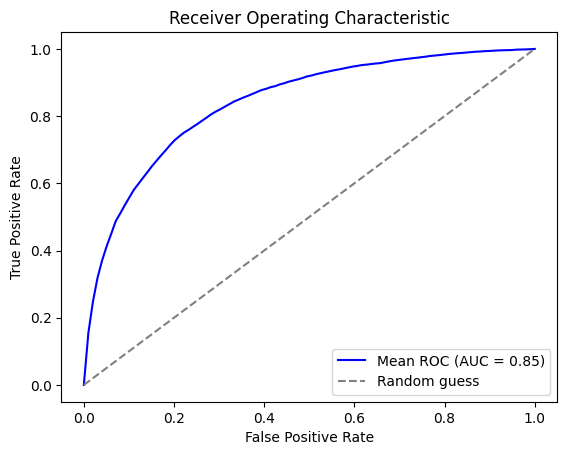

In [233]:
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Feature Importance


Text(0.5, 1.0, 'Feature Importance')

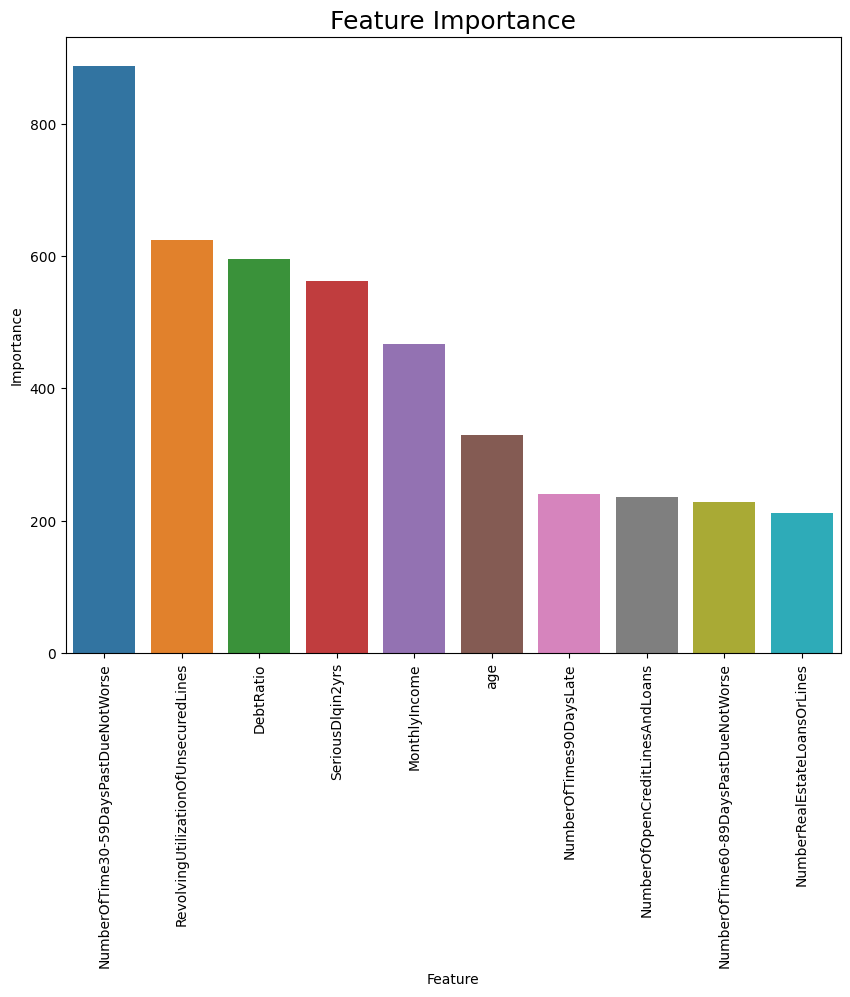

In [289]:
print('Feature Importance')
feature_importance = list(zip(df.columns, clf.feature_importances_))
feature_importance = pd.DataFrame(feature_importance, columns = ['Feature', 'Importance'])
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x = 'Feature', y ='Importance', data=feature_importance)
plt.xticks(rotation = 90)
plt.title('Feature Importance', size=18)

Text(0.5, 0, 'Probability')

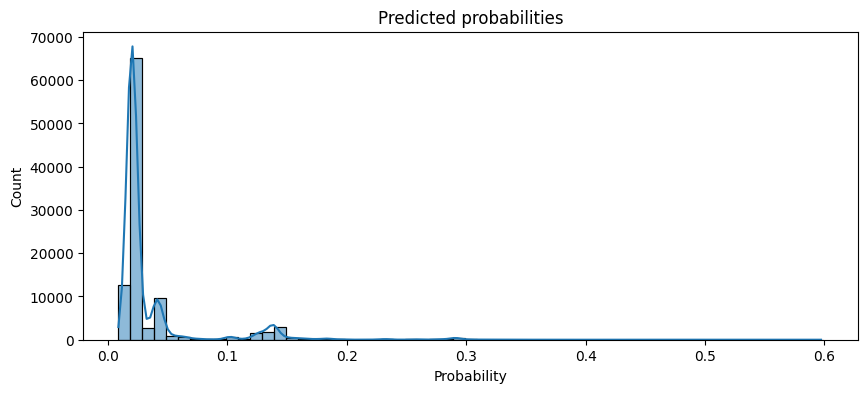

In [241]:
plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

In [279]:
sub = pd.read_csv("data/cs-test.csv", index_col= 0)

In [280]:
sub['SeriousDlqin2yrs'] = preds

In [281]:
sub = sub['SeriousDlqin2yrs'].reset_index().rename(columns={"index": 'id','SeriousDlqin2yrs': 'Probability'})

In [287]:
sub.to_csv('submission.csv', index= False)